# SPAM detection

This project is about SPAM detection. First We need to get some data to explore the different possibility of spam detection.

I found a dataset from kaggle a famous web site which organise machine learning competition. The dataset contain dataset from SMS communication.

Source of data: https://www.kaggle.com/uciml/sms-spam-collection-dataset


## Load Data 

First we need to load and to extract some basic information from the dataset.

In [1]:
# Load data into a pandas DataFrame 
import pandas as pd
import seaborn as sns
df = pd.read_csv('./data/spam.csv', 
                 encoding='latin-1')


## Basic analyse of the data

In [2]:
print("Dataframe information:")
df.info()
print("Dataframe five first lines:")
df.head()
print("Info about the spam information:")
df["v1"].describe()

Dataframe information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
v1            5572 non-null object
v2            5572 non-null object
Unnamed: 2    50 non-null object
Unnamed: 3    12 non-null object
Unnamed: 4    6 non-null object
dtypes: object(5)
memory usage: 217.7+ KB
Dataframe five first lines:
Info about the spam information:


count     5572
unique       2
top        ham
freq      4825
Name: v1, dtype: object

The datasets first column contains the information about the type of sms, if it's a spam the value is "spam" otherwise the value is equal to "ham".
The second column contain sms message.

In [3]:
# Rename column v1 -> type and v2 -> message
df.rename(columns={'v1':'type',
                   'v2':'message'}, 
                 inplace=True)
df.head()

,type,message,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Pourcentage of  spam in the dataset: 13.406317300789663%


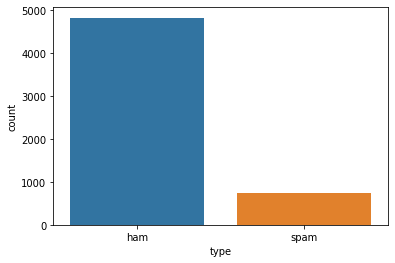

In [4]:
# Analyze of spam distribution
perc_spam = (df["type"].value_counts()['spam']/df.shape[0]) * 100
print(f"Pourcentage of  spam in the dataset: {perc_spam}%")
sns.countplot(df["type"])

## Prepare the data for algorithm

In [5]:
# Remove unused column
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)
df.shape

(5572, 2)

In [6]:
# Use data label encoder from sklearn to apply a one hot encoding 
# on the target, all the spam a values are replace by 1 and the ham value
# is replace by 0. Machine learning algorithm often require number column
from sklearn.preprocessing import LabelEncoder
X = df.message
Y = df.type
Y = LabelEncoder().fit_transform(Y)
Y = Y.reshape(-1,1)

In [7]:
# Randomly split the dataset in two parts
# The first split will be used to 
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [8]:
# Tokenizer
# This step transform sentence into vector to be able to compute a Classification using relevant data 
# We keep only the {max_number} most frequent word to reduce the matrix size
from keras.preprocessing.text import Tokenizer
import keras
max_words = 1000
max_len = 200
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
vec = tok.texts_to_sequences(X_train)
vec_matrix = keras.preprocessing.sequence.pad_sequences(vec,maxlen=max_len)
vec_test = tok.texts_to_sequences(X_test)
vec_test_matrix = keras.preprocessing.sequence.pad_sequences(vec_test, maxlen=max_len)
print(vec_matrix.shape)
print(vec_test_matrix.shape)
# As expected we transformed our texte message to a {max_len} values vector

Using TensorFlow backend.


(4457, 200)
(1115, 200)


## Creation of the neural network model

We decide to use an RNN, recurent neural network, using tensorflow

Some source I use to understand RNN:
- https://www.kaggle.com/shivamb/beginners-guide-to-text-generation-using-lstms
- https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537
- http://colah.github.io/posts/2015-08-Understanding-LSTMs/

I first try to find with my own custom parameters but results was pretty bad, I decide to find some existing parameter for my neural network:
- https://www.kaggle.com/kredy10/simple-lstm-for-text-classification

In [9]:
# Get some core layer to build our network
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words, 40, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = keras.models.Model(inputs=inputs, outputs=layer)
    return model
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])

W0710 23:15:08.537194 19720 deprecation_wrapper.py:119] From C:\Tools\anaconda3\envs\spam\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 23:15:08.644209 19720 deprecation_wrapper.py:119] From C:\Tools\anaconda3\envs\spam\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 23:15:08.648890 19720 deprecation_wrapper.py:119] From C:\Tools\anaconda3\envs\spam\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0710 23:15:09.190366 19720 deprecation_wrapper.py:119] From C:\Tools\anaconda3\envs\spam\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0710 23:15:09.211553 19720 de

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 40)           40000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                26880     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

## Train our model

Now we need to train our model using our first split of data

In [10]:
# The early stopping strategy will stop our training phase if the val_loss does not improve more than a minimal delta
# This avoid overfeating and lost of time
model.fit(vec_matrix,
          Y_train, batch_size=256,
          epochs=20,
          validation_split=0.2,
          callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 3565 samples, validate on 892 samples
Epoch 1/20
3565/3565 [==============================] - 8s 2ms/step - loss: 0.4461 - acc: 0.8320 - val_loss: 0.3296 - val_acc: 0.8643
Epoch 2/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.2191 - acc: 0.8999 - val_loss: 0.1495 - val_acc: 0.9260
Epoch 3/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.1082 - acc: 0.9719 - val_loss: 0.0782 - val_acc: 0.9888
Epoch 4/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.0602 - acc: 0.9854 - val_loss: 0.0370 - val_acc: 0.9899
Epoch 5/20
3565/3565 [==============================] - 6s 2ms/step - loss: 0.0399 - acc: 0.9882 - val_loss: 0.0523 - val_acc: 0.9888


## Test our model on the test split

In [11]:
accuracy = model.evaluate(vec_test_matrix, Y_test)

1115/1115 [==============================] - 1s 911us/step


In [12]:
print(f"Loss value:{accuracy[0]:.3}")
print(f"Model accuracy: {accuracy[1]:.3}")

Loss value:0.0697
Model accuracy: 0.981


## Compare with traditionnal classifier

Now we have our neural network which work. We want to compare the result with some traditonnal classifier.

In [13]:
# Import two traditionnal classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [14]:
# Create the model
knc = KNeighborsClassifier(n_neighbors=30)
svc_sig = SVC(kernel='sigmoid', gamma=1.0)
# Train the model with the data
knc.fit(vec_matrix, Y_train)
svc_sig.fit(vec_matrix, Y_train)

C:\Tools\anaconda3\envs\spam\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """
C:\Tools\anaconda3\envs\spam\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1.0, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [15]:
from sklearn.metrics import accuracy_score
res_knc = knc.predict(vec_test_matrix)
res_svg_sig = svc_sig.predict(vec_test_matrix)
knc_score = accuracy_score(Y_test, res_knc)
svg_sig_score = accuracy_score(Y_test, res_svg_sig)

0.8708520179372198
0.8663677130044843


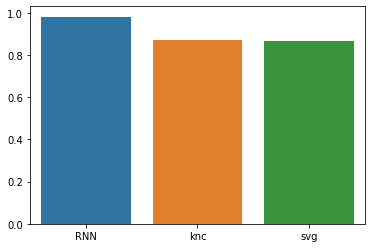

In [22]:
## Conclusion
print(knc_score)
print(svg_sig_score)
sns.barplot(x=['RNN', 'knc', 'svg'], y=[accuracy[1], knc_score, svg_sig_score], alpha=1)


## Conclusion

The best result, I was able to get, is the result obtained from the neural network. It could be because the RNN is more efficient and this case or because the data preparation is more efficient for neural network.

We could have tried to add some features on the data like the count of characters, or to use the punctuation marks contains in messages to improve our models.